In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from imp import reload
import numpy as np
import pandas as pd

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

import voxy

path3 = 'files/model.pkl'

# Vox Report

# Overview
Vox is a popular media company with the slogan of "explain the news."  I first found Vox through youtube where they post short videos explaining a complicated subject in a simple manner.  When I started visiting their web-site, I found that much of their on-line content is political and liberal.  I enjoyed many political articles during the recent election season, but, since the election, I haven't enjoyed the post-election political coverage quite as much.  

I have found that is important to be able to separate their political content from the rest of their content that tends to do a great job explaining something interesting in the world in an accessible and informative way.  Sometimes I am in the mood for political content and sometimes I am not.  Furthermore, my wife also often enjoys their non-political content, but has a lower interest in politics in general.  Lastly, I have relatives that would not appreciate Vox's political positions.  Thus, I believe it would be beneficial to be able to search through Vox's articles and separate them into those that are political and those that are not.  More generally, I separate the articles into those I should "Enjoy Alone" versus those I can "Enjoy Together" with others.  

Throughout this notebook, I describe the process of obtaining, cleaning, and reviewing articles from Vox.  For classification modeling, I find the best set of features by trying different types of tokens and vectorizers, and I tune many different types of models.  I even try some approaches to ensemble the results of the different types of models.  I am able to achieve a very accurate classifier and even understand logical reasons for some of the misclassifications for which I sometimes like the model label better than the supervised label.  I then perform clustering on both the "Enjoy Alone" and "Enjoy Together" classes, and all of this classified and clustered data feeds a search engine as the final step.  

Our newly created Vox search engine allows me to choose between obtaining results of key word searches, of most recent articles, or of recent articles from each class and cluster.  Asking for the most recent articles from each cluster of the "Enjoy Together" class allows me to quickly obtain topic suggestions of current events that I might actually be able to discuss at a family event.  


# Step 1 - Retrieve Data

## Link Scraper
1. Goes to the specified start/stop Vox news search results pages.  
2. Opens the html for each search result page.  
3. Uses regular expressions to find all of the links to individual Vox articles on each search page.  
4. Identifies any new links not already in our article link list.  
5. Adds new links to our dataset.  
6. Uses regular expressions to scrape the article dates from the news links.  
7. Outputs updated dataset.

In [3]:
link_scraper = voxy.LinkScraper(start_page=1, stop_page=15)
link_scraper.scrape(demo=False)

finished at http://www.vox.com/news/1
0 new links added
6752 total links
6752 successful date extractions


## Article Retriever
1. Starts by narrowing down our list of links to those for which we haven't yet obtained the articles.  
2. Retrieves the specified number of articles from the Vox web-site and saves each article to file.  

In [4]:
article_retriever = voxy.ArticleRetriever(number=100)
article_retriever.retrieve(demo=False)

## Article Parser
1. Uses regular expressions and pattern matching to extract each article's title, author, category, and text from the html.  
2. Building this process was very iterative.  I made an attempt and reviewed the output and then tried again.  It took a lot of work to land on an approach that consistently did a good job.  

In [5]:
article_parser = voxy.ArticleParser()
article_parser.parse(demo=False)

parsing complete


# Step 2 - Review data

### Drop Records
1. There is some missing data for logical reasons.  For example, "Vox Sentences" often has missing data, because it is a daily summary and not an actual article.  In this step, the missing data is identified and dropped. 
2. Dates that were text scraped are converted to datetime objects.
3. Vox is saved to a new dataframe and pickled.

In [6]:
reviewer = voxy.Reviewer()
reviewer.drop_records(demo=False)

6752 total articles
---
328 articles with missing data
313 missing title
140 missing author
325 missing category
3 missing text
---
drop records with missing data
---
203 articles from "Vox Sentences" (daily summaries not articles)
drop "Vox Sentences"
---
date converted to datetime object
year-month column added to dataframe
---
6221 articles saved to new dataframe


### Search
1. As I mentioned, the data cleaning process was extremely iterative.  Clean and review, clean and review.  The search method allows me to find all of the articles containing a given regular expression pattern.  The method was integral to finding and eliminating html encoding from the texts.  An example search for Kerry Washington is shown below.  

In [7]:
results = reviewer.search(pattern="Kerry Washington", column="text")
results.head()

4 results found


,link,date,file,title,author,category,text,year_month
3034,http://www.vox.com/2016/6/29/12060846/orlando-...,2016-06-29,3265.0,Watch: 49 celebrities honor the 49 victims of ...,German Lopez,culture,"On June 12, a gunman walked into a gay night...",2016-06
3988,http://www.vox.com/2016/5/18/11695680/abc-sche...,2016-05-18,4315.0,ABC schedule 2016: It's been a rough season. C...,Todd VanDerWerff,culture,"Every May, the TV networks announce their f...",2016-05
4709,http://www.vox.com/2016/4/16/11408576/anita-hi...,2016-04-16,5109.0,How racism and sexism shaped the Clarence Thom...,Victoria M. Massie,policy & politics,After Supreme Court Justice Thurgood Marshal...,2016-04
4906,http://www.vox.com/2016/4/5/11373964/kerry-was...,2016-04-05,5329.0,Kerry Washington on yet another magazine cover...,Caroline Framke,culture,Kerry Washington is on the cover of the Ap...,2016-04


### Print Record
1. It was also imperative for data cleaning and exploration to be able to print and review all of the information extracted for a given article, especially the article text.  The print_record method shown below prints the output for a specified record.

In [8]:
reviewer.print_record(3034)

http://www.vox.com/2016/6/29/12060846/orlando-shooting-lgbtq-tribute
Watch: 49 celebrities honor the 49 victims of the Orlando shooting
German Lopez
culture
2016-06-29
  On June 12, a gunman walked into a gay nightclub in Orlando, Florida, and  shot and killed  49 people. Since then, we have heard a lot about guns, terrorism, and the gunman and his potential motives but we have heard little about the victims.  In  a new video  from the Human Rights Campaign, produced by Ryan Murphy, 49 celebrities come together to share the stories of these victims. The histories reflect the wide range of backgrounds of those who died from a pharmaceutical technician to a computer science college student interested in photography and hip-hop dance; white, black, and Hispanic; teenagers to young adults.  Its absolutely tragic but worth watching in full a necessary reminder of  the cost of hate  and  a society that makes it so easy to kill .  Heres  a full list  of all the victims to the shooting: Edward

### Frequency Plots
1. The freq_plot method counts the number of articles for the requested data column.  You can limit the number of categories using n, and you can sort on the index using sort.  

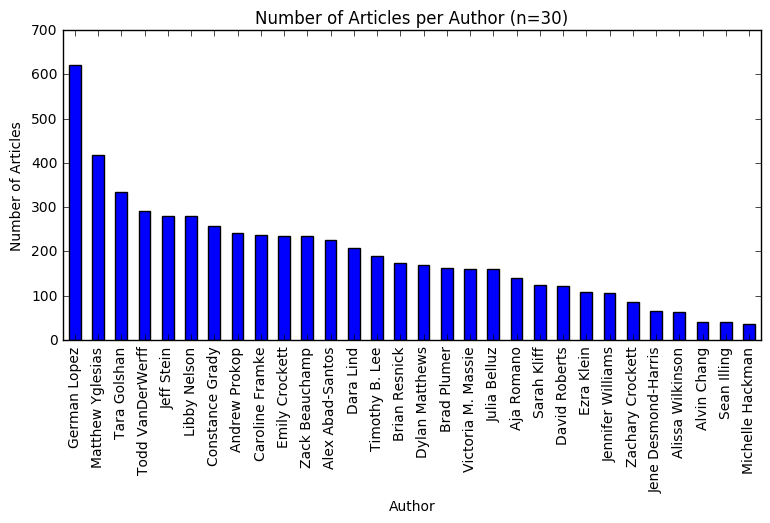

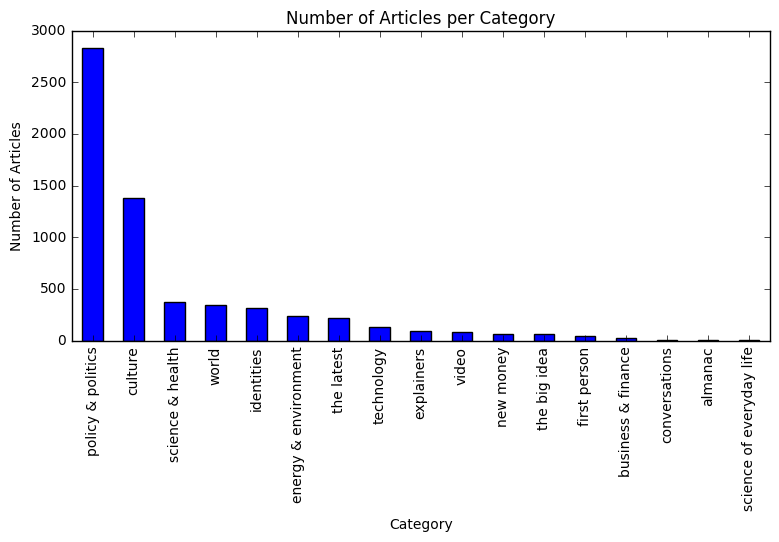

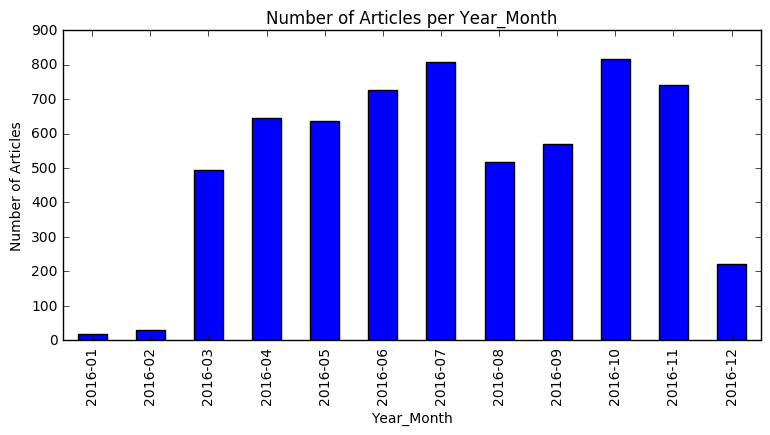

In [9]:
reviewer.freq_plot(column='author', n=30)
reviewer.freq_plot(column='category')
reviewer.freq_plot(column='year_month', sort=True)

### Tokens
1. Tokenize article text using regular expression (same one used in sklearn count vectorizer).  Save as new column of dataframe "tokened."  
2. Stem articles using nltk's snowball stemmer.  Save as new column of dataframe "stemmed." 
3. Lemmatize articles using nltk's wordnet lemmatizer.  Save as new column of dataframe "lemmatized." 

I decided to save each version of the tokens because the dataframe size isn't too large and it will save time later when I want to fit models on different types of tokens.

In [10]:
reviewer.tokenize()

69618 tokens in "tokened"
43320 tokens in "stemmed"
60929 tokens in "lemmatized"


### Histogram
1. Histogram of the number of tokens per article.  

Reviewing the articles with the greatest and fewest number of tokens helped to improve the data extraction and cleaning steps above.  

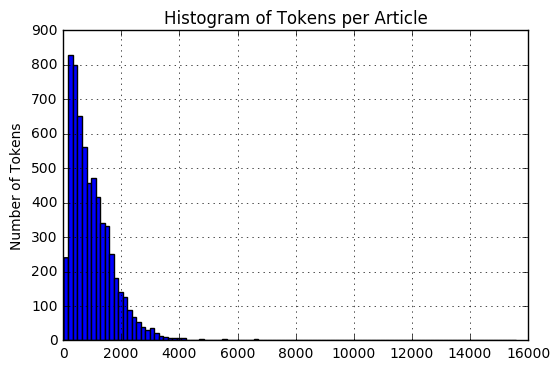

In [11]:
reviewer.token_histogram()

### Zipf's Law
1. Count the number of times each token occurs.  
2. Print the most common tokens.
3. Print plots of Zipf's Law

6257859 total tokens
69618 unique tokens
Top 5: [('the', 340757), ('to', 187006), ('of', 170569), ('and', 160196), ('in', 122653)]


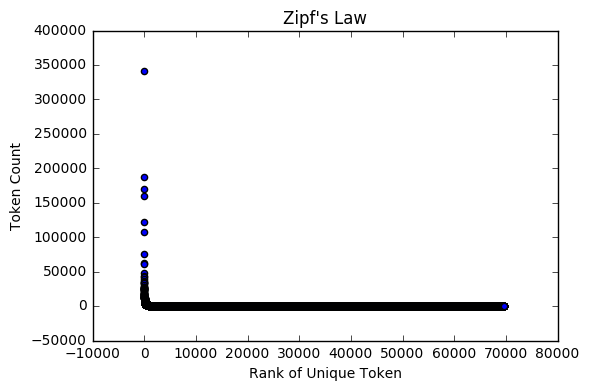

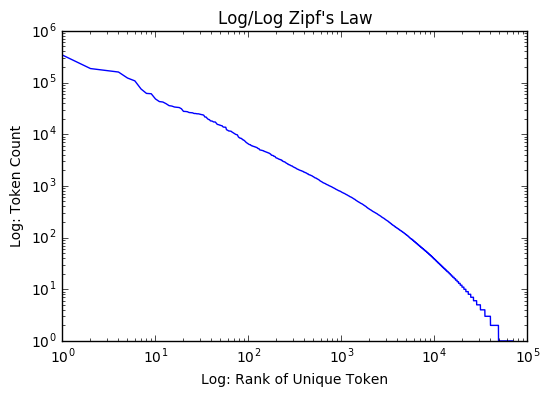

In [12]:
reviewer.zipfs()

### Heaps' Law
1. Make a pass through all of the tokens and keep track of how many tokens you have seen and how many unique tokens you have seen.
2. Plot Heaps' Law

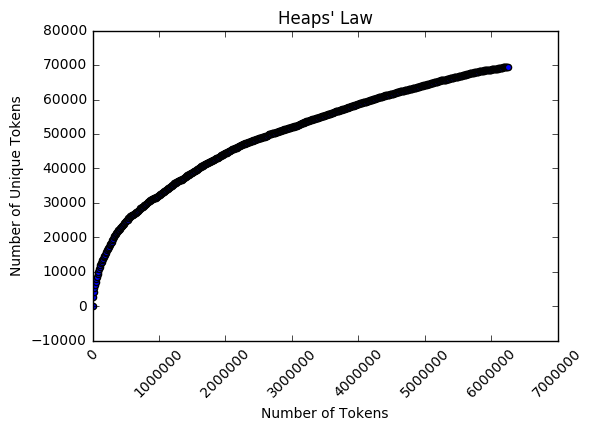

In [13]:
reviewer.heaps()

### Unigram Comparison
1. Another way to clean and explore the data is to compare words from Vox to another corpus.  We start by loading in the unigram word count file.  
2. Compare the number of unique unigrams to the number of tokens in Vox.  
3. Identify the tokens that belong to Vox and aren't contained in the unigrams.  
4. Print the specified number of unique Vox tokens, starting with the most frequent.  

In [14]:
reviewer.compare_unigrams(n=5)

333333 unique unigrams
69618 unique tokens in Vox
13171 tokens in Vox and not unigrams
Top 5 unique to Vox: [('obamas', 757), ('obamacare', 662), ('pokmon', 590), ('brexit', 581), ('voxs', 470)]


# Step 3 - Classification

### Supervised Data
1. As we saw above, Vox categorizes their articles.  We will use the categories to create labels so that we can train a supervised model.  
2. We are going to split the articles into two groups.  The first group contains articles on policy, politics, and other topics that I might enjoy reading, but wouldn't want to discuss at dinner with my relatives (note that it does contain a broader range than just politics, even thought it is convenient to refer to it as political topics elsewhere in the documentation).  The second group contains topics that should closer represent "dinner" appropriate topics.  Since holiday season is in full swing and social gatherings are upon us, it would be good to brush up on current events from the second group of topics.  
3. Immediately below, I have printed out random sample article titles from each of Vox's categories.  After combing through the categories, I came up with the following labels:
    - "Enjoy Alone": policy & politics, world, identities
    - "Enjoy Together": culture, science & health, energy & environment, technology, new money, business & finance
4. A few categories will be excluded during model development.  These categories, like "video", tend to be a hodge podge of topics and have few samples in our dataset.  Since they don't represent a particular category, they won't help us in training the model.  
    - "Exclude": the latest, explainers, video, the big idea, first person, almanac, conversations

In [15]:
voxy.category_samples(n=15)

POLICY & POLITICS
This cartoon lets you try to balance Donald Trump's tax plans. Good luck.
House Democrats are staging a massive sit-in to get failed votes on weak gun bills
Hillary Clinton was firmly pro-Remain. Heres how she reacted to the Brexit vote.
Congressional Democrats have nothing to fear from standing up to Trump, in one chart
Why Obama is banning Cabinet members from speaking at the Democratic convention
Donald Trump's vulgar comments from 2005 could haunt him until Election Day
Brock Turner was convicted of sexual assault but not rape. What does that mean?
4 states are down to one Obamacare insurer. What if they fall to zero?
Evidence that voters aren't angry about the economy after all
Clinton-Kaine: the safe choice isnt a bad message in a race with Donald Trump
Why the word "I" causes Hillary Clinton so much trouble
Trump wins Indiana's primary and probably the GOP nomination
Bill Clintons speech sold Hillarys legacy with a speech only he could deliver
Obama: Not me, no

### Train/Test Split
1. When the splitter class is initialized, observations from "Enjoy Alone" and "Enjoy Together" categories are kept and the others are discarded.  Then train/test indices are randomly generated once for the class.  
2. The split method creates X_train, X_test, y_train, and y_test.  You pass the column of tokens that you want to use for the features (X).  Calling this method again on another feature column (for example, "stemmed" instead of "tokened") will not re-generate the train/test split indices (created during instantiation).  This way, we preserve a true hold out test set, but can still fit models on the different versions of our tokens.  
3. The sample method produces a random sample from the training data of the given size.  This is helpful with small samples while testing new code.    

In [16]:
splitter = voxy.Splitter()
splitter.split(Xcolumn='tokened')
splitter.sample(n=100)

Split(size): X_train(3712), X_test(1999), y_train(3712), ytest(1999)
Sample(size): X_train(100), y_train(100)


### Baseline Accuracy
1. The baseline accuracy is the percentage of articles in the dominant class, "Enjoy Alone."  The baselie accuracy for the training data is printed below.  

In [53]:
print('Baseline Accuracy:', 1-voxy.y_train.mean())

Baseline Accuracy: 0.611260775862


### Model Search Tools
1. The ModelPipe class allows me to build as many custom pipelines as desired, the core features of a pipeline include:
    - Vectorizer - such as tfidf
    - VectorizerGrid - paramater grid for the vectorizer over which I want to search
    - Decomposition - such as non-negative matrix factorizaion
    - DecompositionGrid - paramater grid for the decomposition over which I want to search
    - Model - such as logistic regression
    - ModelGrid - parameter grid for the model over which I want to search
2. As you can see, each pipeline needs to search over all the combinations of vectorizer parameters, decompositions parameters, and model parameters provided.  
3. The ModelSearch class allows me to pass a list of ModelPipe pipelines.  In general, it will search each pipeline for the best parameters and output all of the results from every iterartion of every pipelines for me to analyze.
4. The SparseArray class was built to transform a sparse array into a normal array.  This class is important, because it can work in the middle of any pipeline within gridsearch.  Some of the models, such as Gradient Boost, don't work with a sparse array, so this transformation is used in such cases.  

### Vectorizers
1. Finding a good vectorizer was an iterative process.  I first built pipelines for many different types of models (like the ones we will see later on).  Then I used ModelSearch with many pipelines and parameter options for those pipelines.  I explored the results of the ModelSearch, made conclusions, updated parameter grids, and tried again.  
2. A simple, illustrative example of a ModelSearch with only 1 pipeline (Logistic Regression) and many parameters for the vectorizer grid is shown immediately below.  The plot shows that a range of model test performance is achieved depending on the vectorizer parameters.  For this illustration, I used randomized search with 50 searches on just 500 observations.  This gives us an illustration of the sensitivity of the model to the choice of vectorizer parameters.  
3. As I iterated through many model types and parameters with the full training set, I made the following decisions about the vectorizer parameters in the order stated.  Where no rationale is given, the observed model performance was the reason for the decision. 
    - max_df!=1.0 due to performance and run time.
    - min_df!=1 due to run time.  Also, a term that isn't in at least 2 docs shouldn't help us classify.
    - stop_words='english'
    - norm='l2'
    - ngram_range!=(1, 3) due to performance and runtime.
    - binary=False
    - max_features=None 
    - use_idf=True
    - ngram_range=(1, 2) with very similar performance between (1, 2) and (1, 3) so kept (1, 2) for run time and slight performance edge.  
    - sublinear_tf=False which is default because True or False didn't impact performance.  
    - min_df=2
    - max_df=0.95 as reasonable lower values had almost no impact on the size of the matrix or results.  

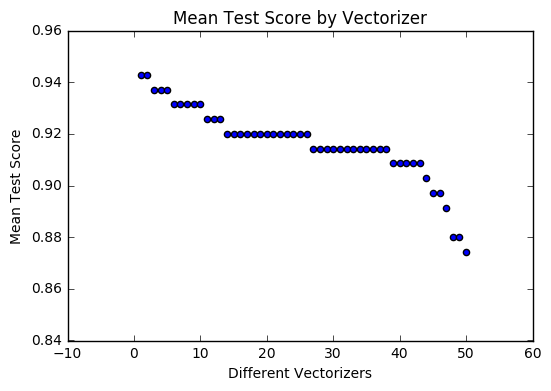

In [55]:
splitter.split(Xcolumn='tokened', pr=False)
splitter.sample(n=500, pr=False)
Lrc = voxy.ModelPipe("Logistic Regression"
                     ,vectorizer=TfidfVectorizer()
                     ,vectorizer_grid={'ngram_range': [(1, 1), (1, 2), (1, 3)]
                                      ,'stop_words': [None, 'english']
                                      ,'max_df': [0.95, .85, 0.75]
                                      ,'min_df': [2, 3, 4, 5, 10]
                                      ,'max_features': [None, 1000, 2500]
                                      ,'binary': [False, True]
                                      ,'norm': ['l2', 'l1']
                                      ,'use_idf': [True, False]
                                      ,'sublinear_tf': [False, True]}
                     ,model=LogisticRegressionCV(penalty='l2')
                     ,search='rand'
                     ,search_n=50)
model_list = [Lrc]
Search = voxy.ModelSearch(model_list, pr=False)
Search.search()
voxy.plot_vectorizer_results(Search.model_results_)

### Tokens
1. The code below shows that we have similar test scores whether we use "tokened," "stemmed," or "lemmatized."  Even though it is using 5 cross folds, the results are so tight that they come out in different orders when the code is re-run.  Since I initially used "lemmatized" when exploring many of the different pipelines that I will discuss below, I will continue to use "lemmatized."  

In [18]:
search_val = StratifiedKFold(n_splits=5)
Lrc = voxy.ModelPipe("Logistic Regression"
                         ,model=LogisticRegressionCV(penalty='l2')
                         ,search_validation=search_val)
model_list = [Lrc]
Search = voxy.ModelSearch(model_list, pr=False)
for tokens in ['tokened', 'stemmed', 'lemmatized']:
    splitter.split(Xcolumn=tokens, pr=False)
    Search.search()
    print('Mean Test Score for {}: {}'.format(tokens, Search.model_results_.mean_test_score[0]))
    
splitter.split(Xcolumn='lemmatized', pr=False)

Mean Test Score for tokened: 0.9331896551724138
Mean Test Score for stemmed: 0.9388469827586207
Mean Test Score for lemmatized: 0.9375


### Best Models
1. This section will discuss parameter tuning for each of many types of models.

#### Logistic Regression
1. I used the LogisticRegressionCV algorithm which is an implementation of penalized regression that will determine the value of the regularizaition/penalty coefficient during the fitting process.  
2. I tested both l1 and l2 types of penalties.  l2 seemed to have the edge.  This seems to makes sense, since our feature matrix is sparse with many correlated features and Ridge Regression can do a good job handling many correlated features.  
3. This model performed great, right out of the box, with no tuning (defaults to 'l2' and even 'l1' did good)!  Because of the regularization, it performed well even on small samples.  It also trained plenty fast enough.  For these reasons, it was a fantastic model that I used and reused as I was developing and testing code.  

In [19]:
Lrc = voxy.ModelPipe("Logistic Regression", model=LogisticRegressionCV(penalty='l2'))

#### K Nearest Neighbors
1. I tried many different values for the number of neighbors and found 7 to work the best.  
2. I created 2 additional knn models using different decompositions to reduce dimensionality prior to fitting knn, and tuned each ModelPipe to find the best numbers of components and neighbors:
    - Truncated SVD (which works well on sparse matrices): 20 components and 7 neighbors
    - Non-negative matrix factorization: 22 components and 7 neighbors

In [20]:
Knn = voxy.ModelPipe('K Nearest Neighbors', model=KNeighborsClassifier(n_neighbors=7))
KnnSvd = voxy.ModelPipe('Knn Svd', decomposition=TruncatedSVD(n_components=20)
                        ,model=KNeighborsClassifier(n_neighbors=7))
KnnNmf = voxy.ModelPipe('Knn Nmf', decomposition=NMF(n_components=22), model=KNeighborsClassifier(n_neighbors=7))

#### Linear Discriminant Analysis
1. LDA doesn't work with sparse matrices.  This is one of the cases where the SparseArray class was able to be added to the pipeline so that everything would fit together.  
2. The conversion from sparse matrix to array created memory and run time issues.  I was able to work around them, only to find the worst performance of all of the models that I tried.  I have left LDA out of the final set of models.  

#### Multinomial Naive Bayes
1. The alpha parameter controls the Laplace smoothing.  The default is 1.  I found alpha to have a significant effect on the results, and the best results were obtained by tuning this parameter down to 0.004.  
2. In a word count context, holding everything else equal, the default smoothing parameter of 1 makes the assumption that a word that was never seen is 50% as likely to be seen as a word that actually was seen once.  The purpose of the smoothing parameter is to give some chance to every word to prevent zero probabilities, but, intuitively, a parameter of 1 seems very high to me (too much weight for unseen words).  I was happy to see that the smoothing parameter had a huge impact on results and needed to be tuned down much closer to 0.   

In [21]:
Mnb = voxy.ModelPipe('Multinomial Naive Bayes', model=MultinomialNB(alpha=0.004))

#### Bernoulli Naive Bayes
1. Like Multinomial Naive Bayes, alpha of 0.004 improved results significantly.  
2. This model also has a binarize parameter which controls the value at which to binarize the feature matrix (meaning 1 if the value is above the binarize parameter and 0 otherwise for all values in the matrix).  I didn't find improvement by increasing the binarize parameter above 0.    

In [22]:
Bnb = voxy.ModelPipe('Bernoulli Naive Bayes', model=BernoulliNB(alpha=0.004, binarize=0))

#### Random Forest
1. I found the best random forest to be "classic" in the sense that it uses bootstrapped samples, grows tress to full, and uses square root features for each split. 
2. I found 250+ trees to be sufficient, but I decided to use 500 for good measure.  

In [23]:
Rfc = voxy.ModelPipe('Random Forest', model=RandomForestClassifier(n_estimators=500, max_features='sqrt'
                                                                   ,max_depth=None, bootstrap=True))

#### Gradient Boosting
1. The Graident Boosting Classifier is another algorithm that doesn't work with sparse matrices.  I first used the SparseArray class to work around this, but run time and memory constraints became problematic, especially when attempting to tune parameters.  
2. I decided to use TruncatedSVD for dimensionality reduction, followed by SparseArray for conversion, and then a Gradient Boosting Classifier.  I found this to work quite well.  
3. I attempted fits with different values for the number of components in the truncated svd.  In one particular run, I received the same results from 25, 50, or 75 components.  I did find some indication of possible, very marginal improvement at a very high number of components, but that just reintroduced performance issues.
4. For the Gradient Boosting Classifier, I tuned the parameters until I finalized on using 5,000 weak learners, each with 'sqrt' features on the splits and a max depth of 2, and a learning rate of 0.02.  

In [24]:
GbcSvd = voxy.ModelPipe('Gbc Svd', decomposition=TruncatedSVD(n_components=25)
                        ,model=GradientBoostingClassifier(learning_rate=.02, n_estimators=5000, max_depth=2
                                                          ,max_features='sqrt'))

### Best Models
1. In this step, we use ModelSearch to fit the best model to each of our model types and output the performance.  
2. I had this output built very early on in while I was trying different pipelines and parameters.  In addition to outputing the test performance, monitoring the run times allowed me to use my time wisely in how I approached tuning each model.  

In [25]:
model_list = [Lrc, Knn, KnnSvd, KnnNmf, Mnb, Bnb, Rfc, GbcSvd]
Search = voxy.ModelSearch(model_list, pr=False)
Search.search()
voxy.results_table(Search.model_results_)

,Mean Test Score,Mean Run Time
Pipe,,
Multinomial Naive Bayes,0.944615,10.272524
Logistic Regression,0.942308,20.784527
Bernoulli Naive Bayes,0.936154,10.087495
Gbc Svd,0.930000,26.242486
Knn Svd,0.920769,10.649722
K Nearest Neighbors,0.918462,9.244243
Knn Nmf,0.917692,27.101135
Random Forest,0.916923,25.255059


### Ensemble
1. I decided to try several different ensembles of the predictions from each of the models above to see if I could obtain an even better classifier.  
2. The ensemble method shown starts by obtaining predictions for each of the "best models" for both the training and hold-out test data (that we haven't touched yet).  The predictions are stored in new feature matrices "X_train_ensemble" and "X_test_ensemble."  
3. Based on a little bit of exploration I performed on the training data (not shown), I decided to fit 3 different types of ensembles: Ridge Logistic Regression, Lasso Logistic Regression, and Random Forest.  These models are fit using "X_train_ensemble" and "y_train."
4. Finally, we are ready to compare the performance of each of our "best models" and "ensemble models" on the hold out test data set.  In order to get the most informative hold out measure, I start by bootstrapping 30 random samples (with replacement of the same size of the hold out) from the hold out test data.  I then score each of the models and ensembles on each of the bootstrapped samples.  The output table shows the summary statistics from each of the 30 samples of the hold out test data.

In [26]:
best_models = list(zip([model.name for model in model_list], Search.best_models_))

ensemble_list = [('Lrc l2 Ensemble', LogisticRegressionCV())
                 ,('Lrc l1 Ensemble', LogisticRegressionCV(solver='liblinear', penalty='l1'))
                 ,('Rfc Ensemble', RandomForestClassifier(500, bootstrap=True))]

Ensemble = voxy.Ensemble(best_models, ensemble_list, samples=30)
Ensemble.fit()
Ensemble.results_table()

,mean,std,min,max
Multinomial Naive Bayes,0.950092,0.004527,0.941471,0.959980
Lrc l2 Ensemble,0.947190,0.005220,0.934967,0.956978
Rfc Ensemble,0.946657,0.004883,0.938469,0.954977
Bernoulli Naive Bayes,0.943372,0.004662,0.934967,0.953477
Logistic Regression,0.942788,0.005306,0.931966,0.952476
Gbc Svd,0.932149,0.006074,0.921461,0.942471
Random Forest,0.928481,0.005845,0.916958,0.938969
Lrc l1 Ensemble,0.928481,0.005845,0.916958,0.938969
Knn Svd,0.928147,0.007282,0.916958,0.943972
K Nearest Neighbors,0.922361,0.006716,0.909955,0.932466


### Model Selection
1. In the process of continuing to work on my project, I have run the above code more than once.  However, I have not made any changes to any of the models since the first time I ran the hold out metrics.  I am going to stay true to the first model that I saw win the hold-out comparison, which is Multinomial Naive Bayes.  
2. Without seeing substantial improvement from any of the ensemble methods, it doesn't make sense to select one of the ensembles, which would be choosing an unnecessarily complex model without the performance justification.
3. During training and before the ensembles, I fit each type of model many, many, many times.  This was a combination of tuning each model, improving the code, choosing tokens and vectorizers, etc.  I noticed that Naive Bayes and/or Logistic Regression were almost always obtaining the top performance.  I believe it makes sense for these models to do so well, given the high dimensionality and sparsity of the feature matrix.  We know Ridge Logistic Regression tackles the high dimensionality through the penalty term, and we also know that Naive Bayes can handle the dimensionality through its posterior probability construct of identifying the most probable class given all of the features.  

### Store Model and Make Predictions
1. This step stores the winning model to file.  
2. It also adds predictions for every article directly to our Vox dataframe.  

In [27]:
joblib.dump(Search.best_models_[4], path3)

['files/model.pkl']

In [28]:
make_predictions = voxy.MakePredictions(missing=False)
make_predictions.predict()

### Confusion Matrix
1. The following is the confusion matrix and performance metrics on the test data for our chosen model.  For the metrics, I treat "Enjoy Together / Enjoy Together" as a "True Positive" (the rest follow thereafter).  

In [29]:
voxy.confusion_matrix(test_df=voxy.vox.loc[splitter.test])

True Negatives	1189	(0.595)
False Positives	38	(0.019)	(Type I Error)
False Negatives	63	(0.032)	(Type II Error)
True Positives	709	(0.355)
Accuracy	0.949
Error		0.051
Recall		0.918
Precision	0.949
F1		0.934

Confusion Matrix:


predicted_label,Enjoy Alone,Enjoy Together
vox_label,,
Enjoy Alone,1189,38
Enjoy Together,63,709


#### Sample Titles
1. The following shows a random sample of articles that were predicted as "Enjoy Alone" but labeled as "Enjoy Together."  As you can see, the model is picking up that many of these articles have something to do with politics or identities.  I actually feel that if I had hand labeled the supervised labels that I would have labeled these as "Enjoy Together," so it is not surprising to see the model predict them this way.  

In [30]:
for t in voxy.vox.title[(voxy.vox.vox_label == 'Enjoy Together') & (voxy.vox.predicted_label == 'Enjoy Alone')].head(20):
    print(t)

Janet Renos long and storied career was plagued by sexist jokes
Want to improve the health of women? Electing a female leader helps.
Louis C.K., Michael Moore, Hillary Clinton, and the rise of benevolent sexism in liberal men
I have heard it pronounced dead hundreds of times: Jason Furman on the future of Obamacare
Fox News has never been as vulnerable as it is right now. Enter Trump TV?
How to confront sexist locker room talk, according to science
Why the Obama administration thinks Obamacare enrollment will go up in 2017
Watch: Stephen Colbert and Laura Benanti's Melania Trump debate "grabbing women by the Billy Bush
The WikiLeaks emails reveal why Hillary Clinton wouldnt support a carbon tax
Its official: The leaked Donald Trump tape has cost Billy Bush his NBC job
Samantha Bee: Republicans arent brave for disavowing Donald Trump. They created him.
Why conservative Christians keep comparing Trumps leaked tape to Beyonc lyrics
Ben & Jerrys supports Black Lives Matter: We have a moral

# Step 4 - Clustering

### Create clusters
1. The following method uses non-negative matrix factorization separately on the "Enjoy Alone" and "Enjoy Together" classifications (predicted with the classification model) to create clusters for each class.  
2. My goal is to use these clusters later on to output the top 10 most recent articles, 1 from each cluster, for either "Enjoy Alone" or "Enjoy Together."  My decision to output the top 10 articles is driving the decisions for the number of clusters selected.  
3. As you can see below, "Enjoy Together" produces a cluster about Trump, Clinton, and the election.  I intend to treat that cluster as "Enjoy Alone," so I output 9 other clusters for "Enjoy Alone" and 11 for "Enjoy Together."  
4. The top 10 words from each cluster is shown as output of the clustering routine.  

In [31]:
voxy.clustering(n_clusters=(9, 11))

Enjoy Alone 1 ('trump', 'republican', 'campaign', 'donald', 'wa', 'ha', 'said', 'party', 'president', 'penny')
Enjoy Alone 2 ('police', 'black', 'officer', 'shooting', 'crime', 'gun', 'people', 'racial', 'white', 'wa')
Enjoy Alone 3 ('sander', 'clinton', 'democratic', 'party', 'bernie', 'primary', 'supporter', 'superdelegates', 'campaign', 'democrat')
Enjoy Alone 4 ('woman', 'abortion', 'sexual', 'men', 'assault', 'gender', 'law', 'court', 'rape', 'said')
Enjoy Alone 5 ('clinton', 'email', 'hillary', 'debate', 'wa', 'obama', 'campaign', 'ha', 'fbi', 'poll')
Enjoy Alone 6 ('voter', 'vote', 'election', 'voting', 'poll', 'party', 'republican', 'democrat', 'state', 'percent')
Enjoy Alone 7 ('delegate', 'cruz', 'state', 'convention', 'kasich', 'win', 'nomination', 'primary', 'republican', 'indiana')
Enjoy Alone 8 ('tax', 'people', 'health', 'state', 'plan', 'american', 'income', 'policy', 'government', 'country')
Enjoy Alone 9 ('eu', 'uk', 'britain', 'brexit', 'european', 'british', 'leave'

### Store cluster assignments
1. The following procedure uses the clustering models to add the cluster assignments for each article to the Vox dataframe.  

In [32]:
assign_clusters = voxy.AssignClusters(missing=False)
assign_clusters.assign()

### Sample Article Titles
1. The following shows some of the sample article titles from the "Enjoy Together Cluster 5," which includes the political keywords.  I looked closer and found that many of the articles were classified by Vox as culture.  You can see many of the sample titles below are related to pop culture, late night, or celeb.  I found that our model was able to "correctly" classify these as "Enjoy Together" (the supervised label), despite many containing political themes.  
2. As mentioned above, I will treat this cluster as "Enjoy Alone" in the search engine below.  

In [33]:
for t in voxy.vox.title[voxy.vox.cluster == 'T5'].tail(20):
    print(t)

Theres no way around it: Donald Trump looks like a disaster for the planet
Those claims that Harambe won 20,000 votes are based on nothing
What front pages of US newspapers look like the morning after Donald Trumps presidential victory
Stephen Colbert couldnt hold it together on live TV
How The Hunger Games anticipated Donald Trumps rise
Joss Whedon, Donald Trump, and the fascist fantasy of the lone superhero
Election Day is super stressful. This live stream of puffins should help.
Who is Taylor Swift voting for? Shell never tell.
Im a comedian. Im used to hecklers. But since Donald Trump, theyve become intolerable.
It's the end of the world as we know it, again
Watch: Jon Stewart can barely keep it together when Stephen Colbert reminds him Trump could be president
Donald Trump is turning his transition into a reality show, too. Thats an ominous sign.
Samantha Bee: Trumps lies about voter fraud have roots in decades of GOP policy
A key Trump donor could make a ton of money from Trump's

# Step 5 - Search Engine

### Search Engine Class
1. The search engine class is used to build and query a search engine for Vox articles.  
2. In the first step, "build", we use tfidf to vectorize the lemmatized articles and store the vectorized data for use with upcoming searches.  
3. The "check_tfidf" method is used to make sure the matrix is working.  Below, we show the insights of the vectorized data for the word "microsoft."  

In [34]:
search_engine = voxy.SearchEngine()
search_engine.build()
search_engine.check_tfidf('microsoft')

6.369 is the idf for the word
28 is the number of articles with the word
0.531 is the max tfidf for this word across all articles
"Why LinkedIn is worth $26 billion to Microsoft" is the article with the max tfidf 


### Search
1. The "search" method performs our article search.  The input text is what you would type into a search box.  
2. We have built the search capabilities with some custom functionality which we will demonstrate with several search examples.  

#### Keyword search
1. Type a keyword into the search and the engine will lemmatize and vectorize the search.  It then uses cosine similarity to compare the search to every article.  It outputs the most similar articles grouped by time period.  That way, you can obtain the most similar article from today if you are looking for a current event and the most similar article from all time if you are looking for something historical.  
2. Follow your keyword search with a carrot ^ followed by a number, ^4, to specify how many articles to return for each timeframe.  If you don't specify a number, the default is 3.  
3. An example is provided for searching "Goldman Sachs" and returning up to 4 results from each timeframe.  
4. December 12, 2016 is the last time I updated the data with new articles from Vox prior to finishing this project.  Thus, December 12 shows up as "today."  

In [35]:
search_engine.search('Goldman Sachs ^4')

TODAY
1) Donald Trumps fiscal stimulus probably wont work
   Matthew Yglesias | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13878864/donald-trump-stimulus


THIS WEEK
1) Goldman Sachs alumni will likely have the 2 top Trump economic policy jobs
   Matthew Yglesias | 2016-12-09
   http://www.vox.com/2016/12/9/13898984/gary-cohn-goldman-sachs-trump
2) Chris Christie has the lowest approval rating one pollster has ever found for a state governor
   Andrew Prokop | 2016-12-06
   http://www.vox.com/policy-and-politics/2016/12/6/13856938/chris-christie-approval-poll
3) A former Tea Party congressman is already ticked off at Trump: Im disappointed
   Sean Illing | 2016-12-08
   http://www.vox.com/policy-and-politics/2016/12/8/13862624/joe-walsh-donald-trump-tea-party-obama-bannon-alt-right-2016-election
4) Senate Democrats aren't spoiling for a fight. They're spoiling for 10 and that's a problem.
   Jeff Stein | 2016-12-10
   http://www.vox.com/policy-and-politics/2016/12/

#### Search for Today's Articles
1. For quick access to the latest news, enter  a carrrot ^ followed by the number of days of news you want to retrieve.  ^ or ^1 retrieves all the articles from today, ^2 the last 2 days, etc.  

In [36]:
search_engine.search('^')

1) What stand your ground laws actually do
   German Lopez | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13875124/stand-your-ground-castle-doctrine-law
2) Russian hackers, Donald Trump, and the 2016 election, explained
   Matthew Yglesias | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13919702/russian-hackers-donald-trump-2016
3) This cruel new policy makes it near impossible for kids to see their incarcerated parents
   Matthew Yglesias | 2016-12-12
   http://www.vox.com/first-person/2016/12/12/13873434/prison-visit-policy-family
4) Hillary Clintons campaign wants the Electoral College briefed on Russian interference
   Jeff Stein | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13922454/hillary-clinton-electors-podesta
5) Donald Trump producing The Celebrity Apprentice is a big conflict of interest for NBC
   Todd VanDerWerff | 2016-12-12
   http://www.vox.com/culture/2016/12/12/13914704/donald-trump-celebrity-apprentice-produce

#### Enjoy Together Clusters
1. Use the greater than symbol > to retrieve the latest article from each of the Enjoy Together clusters.  These articles were first classified as "Enjoy Together" using the classification model, and then clustered using the clustering model.  
2. This feature allows you to quickly access the latest articles from a range of different topics.  This is in contrast to the ^ method (explained directly above) that retrieves the truly most recent articles and which are likely to be dominated by fewer topics, like politics.  

In [37]:
search_engine.search('>')

1) Methane levels in the atmosphere are now rising at their fastest pace in decades
   Brad Plumer | 2016-12-12
   http://www.vox.com/energy-and-environment/2016/12/12/13915950/methane-atmosphere-rise-agriculture
2) 2017 Golden Globe nominations: the complete list
   Todd VanDerWerff | 2016-12-12
   http://www.vox.com/culture/2016/12/12/13914160/golden-globe-nominations-2017
3) This interactive map shows why renewables and natural gas are taking over the US
   Brad Plumer | 2016-12-12
   http://www.vox.com/energy-and-environment/2016/12/12/13914942/interactive-map-cheapest-power-plant
4) The FDA is slowly getting weaker. Heres why thats dangerous.
   Julia Belluz | 2016-12-12
   http://www.vox.com/science-and-health/2016/12/12/13914068/fda-future-trump-jim-oneill
5) Amazons Mozart in the Jungle season 3 offers 2 standout episodes amid a bunch of fluff
   Todd VanDerWerff | 2016-12-11
   http://www.vox.com/culture/2016/12/11/13897160/mozart-in-the-jungle-review-season-3-amazon
6) New tr

#### Enjoy Alone Clusters
1. Use the less than symbol < to retrieve the latest article from each of the "Enjoy Alone" clusters.  

In [38]:
search_engine.search('<')

1) Donald Trumps fiscal stimulus probably wont work
   Matthew Yglesias | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13878864/donald-trump-stimulus
2) What becomes of Black Lives Matter in the age of Trump?
   Sean Illing | 2016-12-12
   http://www.vox.com/2016/12/12/13854372/black-lives-matter-racial-justice-police-brutality-donald-trump-obama
3) Mitch McConnell just backed a bipartisan investigation into whether Russia helped Trump win
   Jeff Stein | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13919604/mitch-mcconnell-russia-trump
4) Donald Trump producing The Celebrity Apprentice is a big conflict of interest for NBC
   Todd VanDerWerff | 2016-12-12
   http://www.vox.com/culture/2016/12/12/13914704/donald-trump-celebrity-apprentice-producer-nbc
5) Hillary Clintons campaign wants the Electoral College briefed on Russian interference
   Jeff Stein | 2016-12-12
   http://www.vox.com/policy-and-politics/2016/12/12/13922454/hillary-clinton-electo

# Appendix- Exploratory Information
1. With the conclusion of Step 5, we have completed an end-to-end process for our Vox data.  The supporting code is found in voxy.py and keeps the above demonstrations free from the clutter of the more than 1,000 lines of code that were written for this project.  
2. In this section, we will use some "ad hoc" coding directly in the notebook to demonstrate further insights and plots that were helpful along the way.  

### Voxy Code Quality Check
1. Pep 8 - The accompanying voxy code is pep8 compliant, with 2 exceptions: There are a handful of text strings that I left on one line rather than splitting them, and there is a recurring non-compliant comparison to false that allows me to find the rows of the dataframe that I need.  
2. Radon - I agree with the methods that radon has recognized as being more complicated.  With that said, those methods had the most complicated tasks to achieve and they belong to classes that received "A" grades.  Also, the overwhelming majority of classes, methods, and functions receive "A" grades.

In [39]:
!pep8 voxy.py

voxy.py:62:25: E712 comparison to False should be 'if cond is False:' or 'if not cond:'
voxy.py:160:44: E712 comparison to False should be 'if cond is False:' or 'if not cond:'
voxy.py:197:80: E501 line too long (92 > 79 characters)
voxy.py:204:80: E501 line too long (85 > 79 characters)
voxy.py:269:33: E712 comparison to False should be 'if cond is False:' or 'if not cond:'
voxy.py:285:80: E501 line too long (83 > 79 characters)
voxy.py:287:33: E712 comparison to False should be 'if cond is False:' or 'if not cond:'
voxy.py:470:80: E501 line too long (113 > 79 characters)
voxy.py:525:80: E501 line too long (80 > 79 characters)
voxy.py:526:80: E501 line too long (80 > 79 characters)


In [40]:
!radon cc voxy.py

voxy.py
    M 210:4 ArticleParser._story_text - C
    M 637:4 ModelSearch._pipeline - C
    M 970:4 SearchEngine.search - B
    M 44:4 LinkScraper.scrape - B
    M 106:4 ArticleRetriever.retrieve - B
    M 738:4 Ensemble.fit - B
    M 147:4 ArticleParser.parse - B
    F 860:0 clustering - A
    M 263:4 Reviewer.drop_records - A
    M 343:4 Reviewer.freq_plot - A
    M 441:4 Reviewer.heaps - A
    F 488:0 category_samples - A
    C 37:0 LinkScraper - A
    C 100:0 ArticleRetriever - A
    M 401:4 Reviewer._tokens - A
    M 467:4 Reviewer.compare_unigrams - A
    M 613:4 ModelSearch.search - A
    M 667:4 ModelSearch._searcher - A
    M 1051:4 SearchEngine._print_result - A
    C 141:0 ArticleParser - A
    C 605:0 ModelSearch - A
    C 730:0 Ensemble - A
    M 770:4 Ensemble._features - A
    M 798:4 MakePredictions.predict - A
    M 816:4 MakePredictions._vox_label - A
    M 906:4 AssignClusters.assign - A
    C 932:0 SearchEngine - A
    M 1042:4 SearchEngine._time_frame - A
    M 92:

### Logistic Regression
1. The plot below compares the coefficients for the Lasso and Ridge ensemble models.  
2. In the case of the correlated features, Lasso performs variable selection and puts the coefficient weights on the "Logistic Regression" and "Random Forest" models.  
3. Ridge spreads the coefficients over the correlated features with some weight on each.  It is interesting to see that it places the lowest weight on Knn, but since there are 3 flavors of Knn models, the cumulative weight on Knn is still in-line with other model types.  

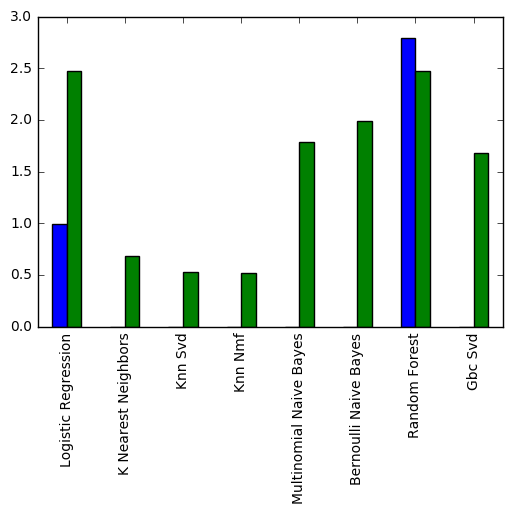

In [41]:
df = pd.concat([pd.DataFrame(Ensemble.models_ensembles_[-2].coef_), pd.DataFrame(Ensemble.models_ensembles_[-3].coef_)])
df.columns = Ensemble.names_[:-3]
df.T.plot.bar(legend=False);

### Knn
1. The plot below is an exaple of looking at the mean test score by K (tuning parameter).  

(Illustrative, using 500 samples to speed up run time).  

Sample(size): X_train(500), y_train(500)


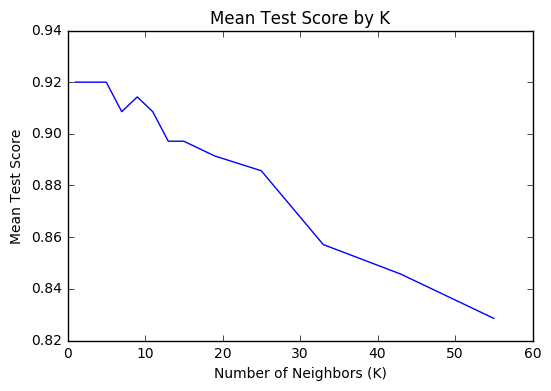

In [42]:
splitter.sample(500)
Knn = voxy.ModelPipe('K Nearest Neighbors', model=KNeighborsClassifier()
                ,model_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 19, 25, 33, 43, 55]})
model_list = [Knn]
Search = voxy.ModelSearch(model_list, pr=False)
Search.search()
voxy.plot_Knn_results(Search.model_results_)

### Multinomial Naive Bayes
1. The plot below is an exaple of the huge improvement we discussed above that is gained by tuning the default Laplace smoothing parameter away from the default value of 1.  

(Illustrative, using 500 samples to speed up run time).  

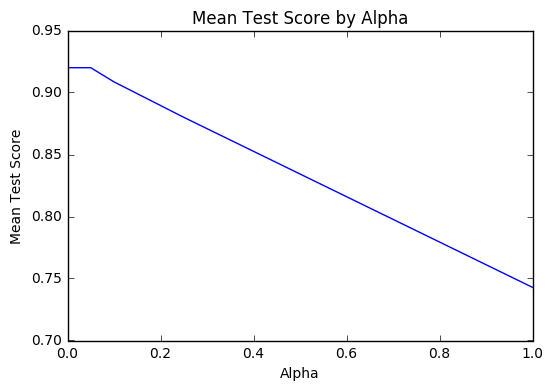

In [43]:
Mnb = voxy.ModelPipe('Multinomial Naive Bayes', model=MultinomialNB(alpha=0.004)
                     ,model_grid={'alpha': [.004, .05, .1, .25, .5, .75, 1]})
model_list = [Mnb]
Search = voxy.ModelSearch(model_list, pr=False)
Search.search()
plt.plot(Search.model_results_.param_model__alpha.values, Search.model_results_.mean_test_score.values)
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score by Alpha');

### Random Forest
1. The plot below is illustrative of the impact of number of trees on the forest.  

(Illustrative, using 500 samples to speed up run time).  

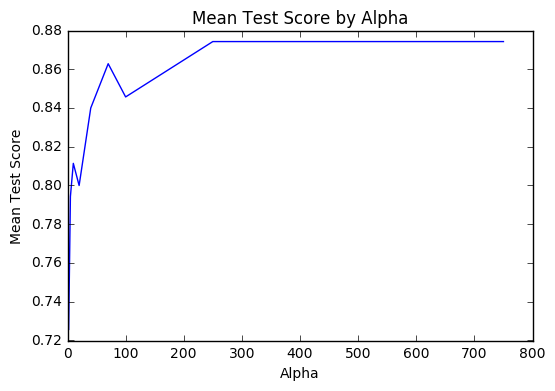

In [44]:
Rfc = voxy.ModelPipe('Random Forest', model=RandomForestClassifier(n_estimators=500, max_features='sqrt'
                                                                   ,max_depth=None, bootstrap=True)
                     ,model_grid={'n_estimators': [2, 5, 10, 20, 40, 70, 100, 250, 500, 750]})
model_list = [Rfc]
Search = voxy.ModelSearch(model_list, pr=False)
Search.search()
plt.plot(Search.model_results_.param_model__n_estimators.values, Search.model_results_.mean_test_score.values)
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score by Alpha');

### Gradient Boosting
1. Below is a stage score plot, which shows how the train and test mse performs at each of the 5,000 stages.  By stage 5,000, the training error is getting close to 0 and the test error has had a chance to run flat for awhile.  

(This illustraion is shown on the full training set, because reducing the number of observations in training causes the training error to approach 0 much faster.)  

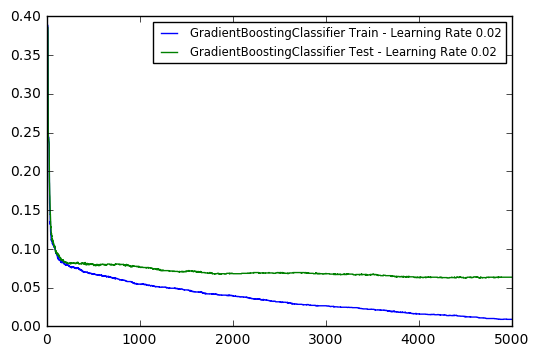

In [45]:
splitter.split(Xcolumn='lemmatized', pr=False)
def sp_mse(staged_predict, y_values):
    "Compute MSE for each stage in staged predict"
    sp = list(staged_predict)
    mse = []
    for stage in sp:
        predict = np.asarray(stage)
        error = (y_values - predict)
        mse.append(error.dot(error) / len(y_values))
    return np.asarray(mse)


GbcSvd = voxy.ModelPipe('Gbc Svd', decomposition=TruncatedSVD(n_components=25)
                        ,model=GradientBoostingClassifier(learning_rate=.02, n_estimators=5000, max_depth=2
                                                          ,max_features='sqrt'))

model_list = [GbcSvd]
Search = voxy.ModelSearch(model_list, pr=False)
Search.search()
model = Search.best_models_[0].best_estimator_.named_steps['model']
vectorizer = Search.best_models_[0].best_estimator_.named_steps['vectorizer']
decomposition = Search.best_models_[0].best_estimator_.named_steps['decomposition']

sp_train = model.staged_predict(decomposition.transform(vectorizer.transform(voxy.X_train)))
sp_test = model.staged_predict(decomposition.transform(vectorizer.transform(voxy.X_test)))
train_mse = sp_mse(sp_train, voxy.y_train)
test_mse = sp_mse(sp_test, voxy.y_test)

plt.plot(train_mse, label=model.__class__.__name__ + ' Train - Learning Rate ' + str(model.learning_rate))
plt.plot(test_mse, label=model.__class__.__name__ + ' Test - Learning Rate ' + str(model.learning_rate))
plt.legend(loc=0, fontsize='small');


### If I had more time
1. If I had more time then I would consider hand labeling some of the data into "Enjoy Alone" and "Enjoy Together" categories based on my personal preferences.  Relying on the Vox categories does a pretty good job, but I might get even better class distinctions from the model if I improved the supervised labels.  The issue with the Vox categories is that there is cross-over in some of the categories, for instance, we saw political articles in the culture bucket.    
2. Many of the classes that I built can be used to add brand new articles to my dataset as Vox publishes them.  For instance, I can run the LinkScraper anytime of day and obtain the new articles that Vox has added.  I can use the ArticleRetriever to obtain the new articles that we found, I can use MakePredictions to add class predictions to those new articles because I saved our chosen model to file, etc.  I am very, very close to being able to have a full update cycle that pulls in the latest articles, cleans, classifies, clusters, and feeds them directly into the search engine.  If I had 1-2 more days to spend on this aspect, I could complete a full production cycle.  The reason my data is actually so fresh (articles through Dec 12) is because the classes were built with an eye towards supporting future production.    

### Reflections
1. What was the biggest challenge?
 - Obtaining each article's text from the html.  I spent a lot of time on a previous approach that got me very close on the majority of articles but still had some issues on a small number of articles.  The current approach is simpler and does a better job.  
2. What did you learn?
 - After using the ModelPipe and ModelSearch classes to tune a variety of models, I began to have my own methodology for working through the process of tuning parameters.  It went a lot faster and smoother after practice with the new classes.
3. If you could hire someone to help, what skill set would you look for?
 - Someone who is experienced with word2vec.  We started learning this late in the class and I didn't have time to explore the implications for this project given the other aspects of the project that I wanted to complete.    
4. What would you tell your past self at the beginning of the course? / What would you tell future students?
 - I would probably tell myself and others to use a package someone else built to scrape html.  On the one hand, it would sae a lot of time.  On the other, I did learn from the experience.  
5. What should I have covered in class to better prepare you to tackle this project?
 - I think I'll have a better idea about this after I obtain instructor feedback!  
6. How would you scale your project?
 - The entire world of Vox articles isn't so large.  I think there could easily be a process to check for new articles and automically add them to the database.  The search engine could be on a web-site instead of an example in Jupyter Notebook.  
7. If you had 2 more weeks, what would you do?
 - See the above section "If I had more time."
8. Would this make a good startup? Why?
 - Not particularly.  The project was aimed specifically at Vox articles and my personal preferences.  Companies, like Vox, that have access to all of their user's usage statistics can use alternative methods to create recommendation systems that will provide personalized article recommendations to all of their users.  
9. Do you want to work in NLP in the future?
 - That depends on the opportunity.  I'm interested in applying analytics to solve problems that real company's face every day.  To the extent that NLP is the best tool for a particular problem, I am intersted in applying it.  